# Set up Phoenix

In [1]:
from phoenix.otel import register
import os
from openinference.instrumentation.openai import OpenAIInstrumentor

project_name = "RAG_Rio"

# Add Phoenix API Key for tracing
phoenix_key = ''
with open('phoenix_key.txt', 'r') as file:
    phoenix_key = file.read()
os.environ["PHOENIX_CLIENT_HEADERS"] = f"api_key={phoenix_key}"
os.environ["PHOENIX_API_KEY"] = phoenix_key
os.environ["PHOENIX_COLLECTOR_ENDPOINT"] = "https://app.phoenix.arize.com"
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"api_key={phoenix_key}";
os.environ['PHOENIX_PROJECT_NAME'] = project_name

# configure the Phoenix tracer
tracer_provider = register(
  project_name=project_name, # Default is 'default'
  auto_instrument=True # Auto-instrument your app based on installed OI dependencies
)
OpenAIInstrumentor().instrument(tracer_provider = tracer_provider)
tracer = tracer_provider.get_tracer(__name__)


Overriding of current TracerProvider is not allowed
Attempting to instrument while already instrumented


🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: RAG_Rio
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: https://app.phoenix.arize.com/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {'api_key': '****', 'authorization': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



# Basic imports and setups

In [2]:
import nest_asyncio
import pandas as pd
import phoenix as px
from basic_rag import MilvusKnowledgeStorage, get_paragraphs
from time import sleep
import datetime

nest_asyncio.apply()

W0917 16:41:31.735000 43207 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/Attila_Sajo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load best dataset from Phoenix

Generated the answer with Anthropic Claude 3 Opus model. No noise

In [3]:
phoenix_client = px.Client()

/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.33.0) and client (11.30.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


In [4]:
dataset_phoenix_name = "qa_data_rio"
df_best = pd.read_json(f"./{dataset_phoenix_name}.json")

In [5]:
try:
    dataset_best = phoenix_client.upload_dataset(
        dataframe=df_best,
        dataset_name=dataset_phoenix_name,
        input_keys=["question"],
        output_keys=["human",  "chatgpt"],
    )
except Exception as e:
    dataset_best = phoenix_client.get_dataset(name=dataset_phoenix_name)

📤 Uploading dataset...


# Write Phoenix evaluation

In [6]:
from phoenix.experiments.evaluators.base import EvaluationResult, Evaluator

In [7]:
from typing import Any, Dict
import torch
from bert_score import score

class BERTScore(Evaluator):
    name="BERT Score"
    def evaluate(self, output: str, expected: Dict[str, Any], **kwargs) -> EvaluationResult:
        expected_answer = expected["chatgpt"]

        # compute Bert score
        # presission, recall and F1
        P, R, F1 = score([output], [expected_answer], lang="en", model_type="ProsusAI/finbert")
        return EvaluationResult(score=F1.numpy(force=True)[0])

In [8]:
import tensorflow_hub as hub
from scipy.spatial import distance

class USESimilarity(Evaluator):
    name="USE"
    def __init__(self):
        super().__init__()
        self.embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")
    def evaluate(self, output: str, expected, **kwargs) -> EvaluationResult:
        embeddings = self.embed([
            output,
            expected["chatgpt"]
        ])

        similarity = 1 - distance.cosine(embeddings[0], embeddings[1])
        return EvaluationResult(score=similarity)

uses = USESimilarity()

In [9]:
from nltk.translate.meteor_score import single_meteor_score
import nltk
"""
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
"""

import re
from nltk.corpus import stopwords

stop_word_list = stopwords.words('english')


def my_tokkenizer(text):
    # különleges karakterek
    pattern = r"[{}]".format("(),.;:%\"") 
    text = re.sub(pattern, "", text)
    
    # kisbetű
    text = text.lower()
    # felesleges üres mezők törlése 
    text = text.strip()
 
    # szavakra vágás
    from nltk.tokenize import WordPunctTokenizer
    WPT = WordPunctTokenizer()
    tokens = WPT.tokenize(text)

    # stop szavak eltávolítása
    filtered_tokens = [
        token for token in tokens 
        if token not in stop_word_list
    ]
    
    # Lemmatize do not need as METEOR handle this also

    return filtered_tokens

class Meteor(Evaluator):
    name="METEOR"
    def evaluate(self, output: str, expected, **kwargs) -> EvaluationResult:
        score = single_meteor_score(my_tokkenizer(output), my_tokkenizer(expected["chatgpt"]))
        return EvaluationResult(score=score)

In [10]:
from scipy.spatial.distance import euclidean
from sentence_transformers import SentenceTransformer, SimilarityFunction

class SBERTFinance(Evaluator):
    name="SBERT finance"
    def __init__(self):
        super().__init__()
        self.model = SentenceTransformer(
            "FinLang/finance-embeddings-investopedia", 
            similarity_fn_name=SimilarityFunction.COSINE
        )
    def evaluate(self, output: str, expected, **kwargs) -> EvaluationResult:
        rag_answer_embeddings = self.model.encode([output])
        expected_embeddings = self.model.encode([expected["chatgpt"]])
        similarity = self. model.similarity(rag_answer_embeddings, expected_embeddings)
        return EvaluationResult(score=similarity.numpy(force=True)[0][0])

finance = SBERTFinance()

In [11]:
class SBERTQwen4(Evaluator):
    name="SBERT Qwen3 4B"
    def __init__(self):
        super().__init__()
        self.model = SentenceTransformer(
            "Qwen/Qwen3-Embedding-4B", 
            similarity_fn_name=SimilarityFunction.COSINE,
            tokenizer_kwargs={"padding_side": "left"},
        )
    def evaluate(self, output: str, expected, **kwargs) -> EvaluationResult:
        rag_answer_embeddings = self.model.encode([output])
        expected_embeddings = self.model.encode([expected["chatgpt"]])
        similarity = self.model.similarity(rag_answer_embeddings, expected_embeddings)
        return EvaluationResult(score=similarity.numpy(force=True)[0][0])

class SBERTQwen06(Evaluator):
    name="SBERT Qwen3 0.6B"
    def __init__(self):
        super().__init__()
        self.model = SentenceTransformer(
            "Qwen/Qwen3-Embedding-0.6B", 
            similarity_fn_name=SimilarityFunction.COSINE,
            model_kwargs={"device_map": "auto"},
            tokenizer_kwargs={"padding_side": "left"},
        )
    def evaluate(self, output: str, expected, **kwargs) -> EvaluationResult:
        rag_answer_embeddings = self.model.encode([output])
        expected_embeddings = self.model.encode([expected["chatgpt"]])
        similarity = self.model.similarity(rag_answer_embeddings, expected_embeddings)
        return EvaluationResult(score=similarity.numpy(force=True)[0][0])

# qwen4 = SBERTQwen4()
qwen06 = SBERTQwen06()

# Evaluate basic RAG

In [12]:
from phoenix.experiments.types import Example
from basic_rag import MyRAG
from phoenix.experiments import run_experiment


def task(input, expected) -> str:
    question = input['question']
    
    
    # mock the RAG generation
    rag_answer = MyRAG().invoke(question)
    
    return rag_answer


In [13]:
df_all_result = pd.DataFrame()

result_file = "rio_validation.json"
if os.path.exists(result_file):
    df_all_result = pd.read_json(result_file)
df_all_result.head()

,name,score,setting,data_load_time
0,SBERT Qwen3 0.6B,0.429993,"{'splitter': 'Semantic', 'model_name': 'Qwen/Q...",156.614143
1,BERT Score,0.504399,"{'splitter': 'Semantic', 'model_name': 'Qwen/Q...",156.614143
2,SBERT Qwen3 0.6B,0.332181,"{'splitter': 'Semantic', 'model_name': 'Qwen/Q...",156.614143
3,BERT Score,0.470052,"{'splitter': 'Semantic', 'model_name': 'Qwen/Q...",156.614143
4,SBERT Qwen3 0.6B,0.843042,"{'splitter': 'Semantic', 'model_name': 'Qwen/Q...",156.614143


In [14]:
splitting_sets = [
     {
        "splitter": "Semantic", 
        "model_name": "Qwen/Qwen3-Embedding-0.6B",
        "breakpoint_threshold_type": "percentile",
        "breakpoint_threshold_amount": 70.0
    },
    {
        "splitter": "Semantic", 
        "model_name": "Qwen/Qwen3-Embedding-0.6B",
        "breakpoint_threshold_type": "percentile",
        "breakpoint_threshold_amount": 80.0
    },
    {
        "splitter": "Semantic", 
        "model_name": "Qwen/Qwen3-Embedding-0.6B",
        "breakpoint_threshold_type": "standard_deviation",
        "breakpoint_threshold_amount": 1.25
    },
    {
        "splitter": "Semantic", 
        "model_name": "FinLang/finance-embeddings-investopedia",
        "breakpoint_threshold_type": "percentile",
        "breakpoint_threshold_amount": 70.0
    },
    {
        "splitter": "Semantic", 
        "model_name": "FinLang/finance-embeddings-investopedia",
        "breakpoint_threshold_type": "standard_deviation",
        "breakpoint_threshold_amount": 1.25
    },
    {
        "splitter": "Agentic",
        "max_content":300,
        "markdown_presplit": False
    },
    {
        "splitter": "Agentic",
        "max_content":60,
        "markdown_presplit": False
    },
    {
        "splitter": "Agentic",
        "max_content":200,
        "markdown_presplit": False
    },
    {
        "splitter": "RecursiveCharacter",
        "chunk_overlap": 0,
        "chunk_size": 1000
    },
        {
        "splitter": "RecursiveCharacter",
        "chunk_overlap": 300,
        "chunk_size": 3000
    },
    {
        "splitter": "Semantic", 
        "model_name": "FinLang/finance-embeddings-investopedia",
        "breakpoint_threshold_type": "percentile",
        "breakpoint_threshold_amount": 70.0,
        "markdown_presplit": False
    },
    {
        "splitter": "Semantic", 
        "model_name": "FinLang/finance-embeddings-investopedia",
        "breakpoint_threshold_type": "standard_deviation",
        "breakpoint_threshold_amount": 1.25,
        "markdown_presplit": False
    },
]

In [15]:
# filter out settings which was tested before
filtered_splitting_sets = []
for splitting_setting in splitting_sets:
    if df_all_result.shape[0] == 0:
        filtered_splitting_sets.append(splitting_setting)
    elif str(splitting_setting) not in set(df_all_result["setting"]):
        filtered_splitting_sets.append(splitting_setting)
print(filtered_splitting_sets)

[{'splitter': 'Agentic', 'max_content': 200, 'markdown_presplit': False}, {'splitter': 'RecursiveCharacter', 'chunk_overlap': 0, 'chunk_size': 1000}, {'splitter': 'RecursiveCharacter', 'chunk_overlap': 300, 'chunk_size': 3000}, {'splitter': 'Semantic', 'model_name': 'FinLang/finance-embeddings-investopedia', 'breakpoint_threshold_type': 'percentile', 'breakpoint_threshold_amount': 70.0, 'markdown_presplit': False}, {'splitter': 'Semantic', 'model_name': 'FinLang/finance-embeddings-investopedia', 'breakpoint_threshold_type': 'standard_deviation', 'breakpoint_threshold_amount': 1.25, 'markdown_presplit': False}]


In [16]:
# run the different experiments
for splitting_setting in filtered_splitting_sets:
    start_timestamp = datetime.datetime.now()
    
    paragraphs = get_paragraphs(
        ticker="RIO",
        max_lenght=200,
        **splitting_setting  # Unpack the rest of the settings dynamically
    )

    try:
        knowledge = MilvusKnowledgeStorage()
    except:
        # retry
        sleep(1)
        knowledge = MilvusKnowledgeStorage()
    knowledge.initialize_knowledge_storage()

    # load data
    documents = [ doc.page_content for doc in paragraphs]
    metadata = [ doc.metadata for doc in paragraphs]
    knowledge.save(documents=documents, metadata=metadata)

    data_load_timestamp = datetime.datetime.now()

    experiment = run_experiment(
        dataset_best,
        task,
        experiment_name="rag-experiment",
        evaluators=[qwen06, BERTScore() ],
        experiment_metadata=splitting_setting
    )

    try:
        evaluation_result = experiment.get_evaluations()
    except:
        evaluation_result = experiment.get_evaluations()

    evaluation_result_filtered = pd.DataFrame({
        "name": evaluation_result["name"].values,
        "score": evaluation_result["score"].values,
        "setting": str(splitting_setting),
        "data_load_time": (data_load_timestamp-start_timestamp).total_seconds()
    })

    df_all_result = pd.concat([df_all_result, evaluation_result_filtered])
    df_all_result.to_json(result_file, orient="records")

Openrouter model qwen/qwen3-30b-a3b:free
Processing: knowledge/rio_20210323_20210323_qa_1.pdf file


Processing chunks:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 200/214 [00:10<00:00, 18.92it/s]


Processing: knowledge/rio_20231009_20231009_qa_1.pdf file


Processing chunks:  80%|██████████████████████████████████████████████████████████████████████████████████████████▉                       | 375/470 [00:15<00:03, 25.00it/s]


Processing: knowledge/rio_20210323_20210323_qa_2.pdf file


Processing chunks:   0%|                                                                                                                            | 0/130 [00:04<?, ?it/s]


Processing: knowledge/rio_20230516_20230516_qa_1.pdf file


Processing chunks:   0%|                                                                                                                            | 0/167 [00:05<?, ?it/s]


Processing: knowledge/rio_20240924_20240924_qa_1.pdf file


Processing chunks:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 778/854 [00:23<00:02, 33.68it/s]


Processing: knowledge/rio_20180618_20180618_qa_1.pdf file


Processing chunks:  83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                   | 200/242 [00:14<00:03, 13.83it/s]


Processing: knowledge/rio_20230711_20230711_qa_1.pdf file


Processing chunks:  83%|██████████████████████████████████████████████████████████████████████████████████████████████▌                   | 200/241 [00:14<00:03, 13.64it/s]


Processing: knowledge/rio_20200512_20200512_qa_1.pdf file


Processing chunks:   0%|                                                                                                                             | 0/80 [00:02<?, ?it/s]


Processing: knowledge/rio_20210518_20210518_qa_1.pdf file


Processing chunks:   0%|                                                                                                                            | 0/127 [00:04<?, ?it/s]


Processing: knowledge/rio_20241009_20241009_qa_1.pdf file


Processing chunks:  64%|█████████████████████████████████████████████████████████████████████████▌                                        | 198/307 [00:11<00:06, 16.78it/s]


Processing: knowledge/rio_20250101_20250501_qa_1.pdf file


Processing chunks:  80%|███████████████████████████████████████████████████████████████████████████████████████████▋                      | 770/957 [00:41<00:10, 18.39it/s]


Create knowledge collection
Loading data. Size: 119416
🧪 Experiment started.
📺 View dataset experiments: https://app.phoenix.arize.com/datasets/RGF0YXNldDoxNg==/experiments
🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoxNg==/compare?experimentId=RXhwZXJpbWVudDoxMTc=


/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.33.0) and client (11.30.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


running tasks |          | 0/22 (0.0%) | ⏳ 00:00<? | ?it/s

Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |          | 0/44 (0.0%) | ⏳ 00:00<? | ?it/s

/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.33.0) and client (11.30.0) versions are mismatched and may have compatibility issues.
  warnings.warn(



🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoxNg==/compare?experimentId=RXhwZXJpbWVudDoxMTc=

Experiment Summary (09/17/25 04:52 PM +0200)
--------------------------------------------
| evaluator        |   n |   n_scores |   avg_score |
|:-----------------|----:|-----------:|------------:|
| BERT Score       |  22 |         22 |    0.571746 |
| SBERT Qwen3 0.6B |  22 |         22 |    0.597052 |

Tasks Summary (09/17/25 04:51 PM +0200)
---------------------------------------
|   n_examples |   n_runs |   n_errors |
|-------------:|---------:|-----------:|
|           22 |       22 |          0 |
Processing: knowledge/rio_20210323_20210323_qa_1.pdf file
Processing: knowledge/rio_20231009_20231009_qa_1.pdf file
Processing: knowledge/rio_20210323_20210323_qa_2.pdf file
Processing: knowledge/rio_20230516_20230516_qa_1.pdf file
Processing: knowledge/rio_20240924_20240924_qa_1.pdf file
Processing: knowledge/rio_20180618_20180618_qa_1.pdf file
Processing: knowle

/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.33.0) and client (11.30.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


running tasks |          | 0/22 (0.0%) | ⏳ 00:00<? | ?it/s

Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |          | 0/44 (0.0%) | ⏳ 00:00<? | ?it/s

/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.33.0) and client (11.30.0) versions are mismatched and may have compatibility issues.
  warnings.warn(



🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoxNg==/compare?experimentId=RXhwZXJpbWVudDoxMTg=

Experiment Summary (09/17/25 05:00 PM +0200)
--------------------------------------------
| evaluator        |   n |   n_scores |   avg_score |
|:-----------------|----:|-----------:|------------:|
| BERT Score       |  22 |         22 |    0.549484 |
| SBERT Qwen3 0.6B |  22 |         22 |    0.556283 |

Tasks Summary (09/17/25 05:00 PM +0200)
---------------------------------------
|   n_examples |   n_runs |   n_errors |
|-------------:|---------:|-----------:|
|           22 |       22 |          0 |
Processing: knowledge/rio_20210323_20210323_qa_1.pdf file
Processing: knowledge/rio_20231009_20231009_qa_1.pdf file
Processing: knowledge/rio_20210323_20210323_qa_2.pdf file
Processing: knowledge/rio_20230516_20230516_qa_1.pdf file
Processing: knowledge/rio_20240924_20240924_qa_1.pdf file
Processing: knowledge/rio_20180618_20180618_qa_1.pdf file
Processing: knowle

/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.33.0) and client (11.30.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


running tasks |          | 0/22 (0.0%) | ⏳ 00:00<? | ?it/s

Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |          | 0/44 (0.0%) | ⏳ 00:00<? | ?it/s

/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.33.0) and client (11.30.0) versions are mismatched and may have compatibility issues.
  warnings.warn(



🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoxNg==/compare?experimentId=RXhwZXJpbWVudDoxMTk=

Experiment Summary (09/17/25 05:08 PM +0200)
--------------------------------------------
| evaluator        |   n |   n_scores |   avg_score |
|:-----------------|----:|-----------:|------------:|
| BERT Score       |  22 |         22 |    0.533395 |
| SBERT Qwen3 0.6B |  22 |         22 |    0.522567 |

Tasks Summary (09/17/25 05:07 PM +0200)
---------------------------------------
|   n_examples |   n_runs |   n_errors |
|-------------:|---------:|-----------:|
|           22 |       22 |          0 |
Processing: knowledge/rio_20210323_20210323_qa_1.pdf file
Processing: knowledge/rio_20231009_20231009_qa_1.pdf file
Processing: knowledge/rio_20210323_20210323_qa_2.pdf file
Processing: knowledge/rio_20230516_20230516_qa_1.pdf file
Processing: knowledge/rio_20240924_20240924_qa_1.pdf file
Processing: knowledge/rio_20180618_20180618_qa_1.pdf file
Processing: knowle

/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.33.0) and client (11.30.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


running tasks |          | 0/22 (0.0%) | ⏳ 00:00<? | ?it/s

Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |          | 0/44 (0.0%) | ⏳ 00:00<? | ?it/s

/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.33.0) and client (11.30.0) versions are mismatched and may have compatibility issues.
  warnings.warn(



🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoxNg==/compare?experimentId=RXhwZXJpbWVudDoxMjA=

Experiment Summary (09/17/25 05:16 PM +0200)
--------------------------------------------
| evaluator        |   n |   n_scores |   avg_score |
|:-----------------|----:|-----------:|------------:|
| BERT Score       |  22 |         22 |    0.545284 |
| SBERT Qwen3 0.6B |  22 |         22 |    0.554053 |

Tasks Summary (09/17/25 05:16 PM +0200)
---------------------------------------
|   n_examples |   n_runs |   n_errors |
|-------------:|---------:|-----------:|
|           22 |       22 |          0 |
Processing: knowledge/rio_20210323_20210323_qa_1.pdf file
Processing: knowledge/rio_20231009_20231009_qa_1.pdf file
Processing: knowledge/rio_20210323_20210323_qa_2.pdf file
Processing: knowledge/rio_20230516_20230516_qa_1.pdf file
Processing: knowledge/rio_20240924_20240924_qa_1.pdf file
Processing: knowledge/rio_20180618_20180618_qa_1.pdf file
Processing: knowle

/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.33.0) and client (11.30.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


running tasks |          | 0/22 (0.0%) | ⏳ 00:00<? | ?it/s

Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
Openrouter model qwen/qwen3-30b-a3b:free
✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |          | 0/44 (0.0%) | ⏳ 00:00<? | ?it/s

/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.33.0) and client (11.30.0) versions are mismatched and may have compatibility issues.
  warnings.warn(



🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoxNg==/compare?experimentId=RXhwZXJpbWVudDoxMjE=

Experiment Summary (09/17/25 05:24 PM +0200)
--------------------------------------------
| evaluator        |   n |   n_scores |   avg_score |
|:-----------------|----:|-----------:|------------:|
| BERT Score       |  22 |         22 |    0.565305 |
| SBERT Qwen3 0.6B |  22 |         22 |    0.586759 |

Tasks Summary (09/17/25 05:24 PM +0200)
---------------------------------------
|   n_examples |   n_runs |   n_errors |
|-------------:|---------:|-----------:|
|           22 |       22 |          0 |


In [17]:
import plotly.express as plotly_express
import plotly.graph_objects as plotly_go

custom_template = {
    "layout": plotly_go.Layout(
        font={
            "family": "Nunito",
            "size": 12,
            "color": "#707070",
        },
        title={
            "font": {
                "family": "Lato",
                "size": 18,
                "color": "#1f1f1f",
            },
        },
        plot_bgcolor="#ffffff",
        paper_bgcolor="#ffffff",
        colorway=plotly_express.colors.qualitative.G10,
    )
}

def format_title(title, subtitle=None, subtitle_font_size=14):
    title = f'<b>{title}</b>'
    if not subtitle:
        return title
    subtitle = f'<span style="font-size: {subtitle_font_size}px;">{subtitle}</span>'
    return f'{title}<br>{subtitle}'

In [18]:
df_all_result.sort_values(["name", "setting"], inplace=True)

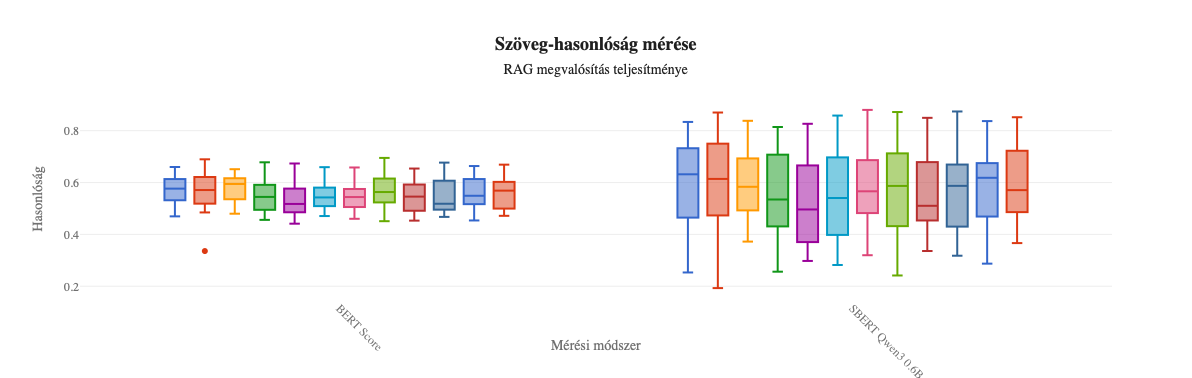

In [23]:
# Create a boxplot using Plotly
fig = plotly_express.box(
    df_all_result,
    x="name",
    y="score",
    color="setting",
    title=format_title("Szöveg-hasonlóság mérése", "RAG megvalósítás teljesítménye"),
    labels={"name": "Evaluation Type", "score": "Similarity Score",  "setting": "Setting"},
    template=custom_template
)

# Customize the layout
fig.update_layout(
    xaxis_title="Mérési módszer",
    yaxis_title="Hasonlóság",
    xaxis=dict(tickangle=45),
    showlegend=False
)

# Show the plot
fig.show()
# save
fig.write_html(result_file.replace(".json", ".html"))

In [20]:
df_all_result.to_json(result_file, orient="records")

# Cleaning up

To cleanup the unnecessary HuggingFace models run the following command: huggingface-cli delete-cache